# Hammanskraal, Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on five spiral arms.  This notebook will use measurements to infer the actual layout of the antennas.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
site_name = 'za-hammanskraal'
x0 = [0,0]
global_rot_degrees = 0
global_rot_index = 16

In [3]:
import pandas as pd

cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('antenna_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      350.0
A 1      914.0
A 2     1295.0
A 3     1545.0
A 4     1770.0
A 5      274.0
A 6      830.0
A 7     1324.0
A 8     1616.0
A 9     1776.0
A 10     230.0
A 11     898.0
A 12    1240.0
A 13    1535.0
A 14    1805.0
A 15     385.0
A 16     940.0
A 17    1295.0
A 18    1530.0
A 19    1786.0
A 20     365.0
A 21    1060.0
A 22    1440.0
A 23    1780.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
n_ant = 24
m_0 = np.zeros(n_ant)
m_ij = np.zeros((n_ant,n_ant))

radius = data.loc[0]

for i in range(n_ant):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

m_ij


array([[  nan,  594., 1020., 1335., 1645.,  379.,  874., 1456., 1845.,
        2050.,  558., 1235., 1597., 1883., 2113.,  712., 1182., 1467.,
        1623., 1743.,  419.,  880., 1144., 1411.],
       [ 594.,   nan,  500.,  915., 1355.,  797.,  998., 1616., 2113.,
        2385., 1080., 1725., 2130., 2467., 2700., 1302., 1765., 1988.,
        2065., 2075.,  973., 1081., 1034.,  987.],
       [1020.,  500.,   nan,  445.,  945., 1091., 1010., 1560., 2113.,
        2436., 1400., 1965., 2400., 2782., 3095., 1695., 2200., 2471.,
        2570., 2570., 1435., 1575., 1450., 1170.],
       [1335.,  915.,  445.,   nan,  519., 1290., 1001., 1396., 1960.,
        2308., 1574., 2026., 2470., 2915., 3298., 1935., 2477., 2797.,
        2941., 2987., 1754., 2000., 1899., 1589.],
       [1645., 1355.,  945.,  519.,   nan, 1493., 1035., 1190., 1725.,
        2097., 1740., 2046., 2484., 2955., 3415., 2135., 2694., 3070.,
        3279., 3375., 2050., 2414., 2375., 2095.],
       [ 379.,  797., 1091., 1290.,

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [6]:
import json
import requests

def get_data(path):
    server = "https://api.elec.ac.nz/tart/zm-cbu/"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if True:
    with open('hammanskraal_antenna_positions_nonaligned.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    current_pos = cal_json["ant_pos"]
    current_pos = np.array(current_pos)
else:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))


9.21035503518459 336.4607161574636
136.6869511171387 817.0183633480439
407.357893124816 1126.9191566942775
721.1970469518101 1271.250237085989
1068.4561577697891 1303.9004053248855
322.8393128089888 95.21251105861754
819.2692291994522 122.47554343847933
1197.6443190802734 -39.183208015404794
1431.892965623525 -293.06122367358904
1570.2540875795492 -613.2348070048687
190.31531318542983 -277.6161481690127
369.64927846505077 -741.3243147124496
332.82700250001744 -1151.1357110360552
163.7614740554133 -1452.3720341009023
-97.9857606721734 -1682.9003591383764
-205.21798068081205 -266.78872645289437
-590.8134111911762 -580.639166617497
-991.9459191615168 -672.2577870686544
-1330.6828086094952 -604.5540577105907
-1630.8126180884651 -426.85481462205286
-317.1470003487909 112.73164740582592
-734.792047590465 382.4695745434232
-945.8832955435901 735.6575494258373
-986.1686780212533 1078.7370783990916


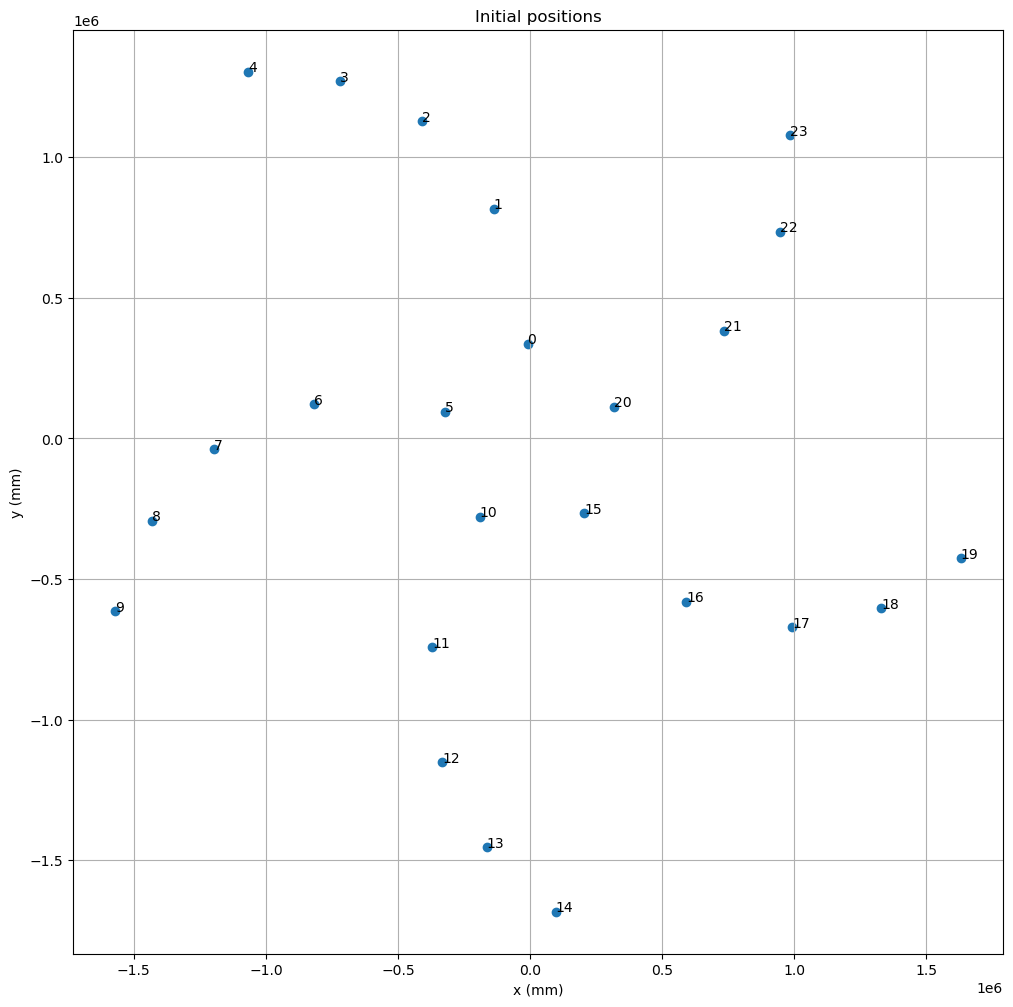

In [7]:
def i_y(i):
    return 2*i+1

def i_x(i):
    return 2*i


initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    initial_guess[i_x(i)] = -x
    initial_guess[i_y(i)] = y
    
    print(x,y)

pos_i = initial_guess.reshape((24,2))*1000
#pos_i = current_pos*1000

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1])
for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [8]:
def geo_angle(x,y):
    return 90 - np.degrees(np.arctan2(y,x))

geo_angle(1,0)

np.float64(90.0)

In [9]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def p(x, i):
    return [x[i_x(i)],x[i_y(i)]]

max_err = 4200
def bounds():
    ret = [(0,0)]*48
    for i in range(n_ant):
        _x,_y = pos_i[i,0], pos_i[i,1]
        ret[i_x(i)] = (_x - max_err, _x + max_err)
        ret[i_y(i)] = (_y - max_err, _y + max_err)
    
    return ret

bnd = bounds()

center = [0,0]

def angle(x, i):
    _x, _y = p(x, i)
    return geo_angle(_x, _y)
    
def radius_model(x):
    ret = []
    
    for i in range(n_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(n_ant):
        p_i = p(x,i)

        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return (predict - radius)

def m_ij_residual(x):
    predict = m_ij_model(x)
    return (predict - non_nan_ij)/10

def rot_residual(x):
    predict = angle(x, global_rot_index)
    return (predict - global_rot_degrees)*10

def f_old(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)
    ret += np.sum(m_ij_residual(x)**2)
    ret += rot_residual(x)**2
    return ret


In [10]:
print(f(initial_guess))

2424888.6305620205


 We can see that the initial value of this optimality condition is about 50 million.

In [11]:
res = minimize(f, initial_guess, bounds=None, options={'maxiter': 500})
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 735.8348190241298
        x: [-2.776e+02 -2.154e+02 ... -1.551e+03 -8.632e+02]
      nit: 141
      jac: [-7.629e-06 -3.052e-05 ...  8.392e-05  1.068e-04]
 hess_inv: [[ 3.048e-01 -1.633e-01 ...  4.869e-02 -2.901e-02]
            [-1.633e-01  5.640e-01 ...  1.343e-02  2.755e-02]
            ...
            [ 4.869e-02  1.343e-02 ...  1.641e-01 -5.638e-02]
            [-2.901e-02  2.755e-02 ... -5.638e-02  4.497e-02]]
     nfev: 10535
     njev: 215

In [12]:
err = res.jac.reshape((24,2))
rms = err # np.sqrt(np.sum(err**2, axis=1))
for i in range(24):
    print(f"Ant {i}:\tJac: {rms[i,0]:06.2f}, \t{rms[i,1]:06.2f}")

Ant 0:	Jac: -00.00, 	-00.00
Ant 1:	Jac: -00.00, 	000.00
Ant 2:	Jac: 000.00, 	000.00
Ant 3:	Jac: -00.00, 	-00.00
Ant 4:	Jac: 000.00, 	000.00
Ant 5:	Jac: -00.00, 	-00.00
Ant 6:	Jac: -00.00, 	000.00
Ant 7:	Jac: 000.00, 	000.00
Ant 8:	Jac: -00.00, 	-00.00
Ant 9:	Jac: 000.00, 	000.00
Ant 10:	Jac: 000.00, 	000.00
Ant 11:	Jac: -00.00, 	000.00
Ant 12:	Jac: 000.00, 	-00.00
Ant 13:	Jac: -00.00, 	-00.00
Ant 14:	Jac: 000.00, 	-00.00
Ant 15:	Jac: 000.00, 	-00.00
Ant 16:	Jac: -00.00, 	000.00
Ant 17:	Jac: 000.00, 	000.00
Ant 18:	Jac: -00.00, 	-00.00
Ant 19:	Jac: -00.00, 	000.00
Ant 20:	Jac: -00.00, 	-00.00
Ant 21:	Jac: -00.00, 	000.00
Ant 22:	Jac: -00.00, 	000.00
Ant 23:	Jac: 000.00, 	000.00


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [13]:
pos = res.x.reshape((24,2))
pos

array([[-2.77557139e+02, -2.15383995e+02],
       [-5.48688094e+02, -7.34561101e+02],
       [-4.28502876e+02, -1.22373107e+03],
       [-1.06196642e+02, -1.54088966e+03],
       [ 3.64073986e+02, -1.73335460e+03],
       [ 9.18716776e+01, -2.61214476e+02],
       [ 4.38847058e+02, -7.06995859e+02],
       [ 1.06685875e+03, -7.82811209e+02],
       [ 1.54352606e+03, -4.81716137e+02],
       [ 1.76658113e+03, -1.81552016e+02],
       [ 2.31160200e+02,  3.32099633e-01],
       [ 8.61041461e+02,  2.53564707e+02],
       [ 1.05566927e+03,  6.50095160e+02],
       [ 1.00726216e+03,  1.15594897e+03],
       [ 6.75916722e+02,  1.67167232e+03],
       [ 1.00875342e+02,  3.74304361e+02],
       [-1.20597328e-04,  9.39090104e+02],
       [-3.98384455e+02,  1.23461012e+03],
       [-8.52922731e+02,  1.28039924e+03],
       [-1.33668589e+03,  1.18218955e+03],
       [-3.05289138e+02,  2.00495408e+02],
       [-1.03624745e+03,  2.26003629e+02],
       [-1.42744812e+03, -1.76269987e+02],
       [-1.

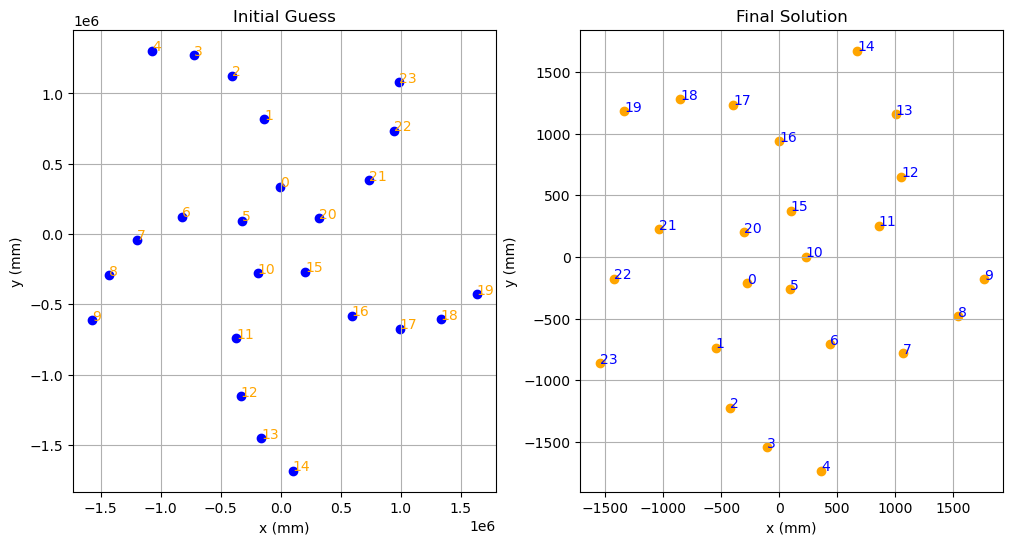

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))


ax[0].scatter(pos_i[:,0], pos_i[:,1], label='initial', color='blue')
for i in range(0,pos_i.shape[0]):
    ax[0].text(pos_i[i,0], pos_i[i,1],f"{i}", color='orange')
ax[0].set_title('Initial Guess')
ax[0].grid(True)
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('y (mm)')

ax[1].scatter(pos[:,0], pos[:,1], label='final', color='orange')
for i in range(0,pos.shape[0]):
    ax[1].text(pos[i,0], pos[i,1],f"{i}", color='blue')
ax[1].set_title('Final Solution')
ax[1].grid(True)
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('y (mm)')
plt.savefig('final_positions.png')
plt.show()

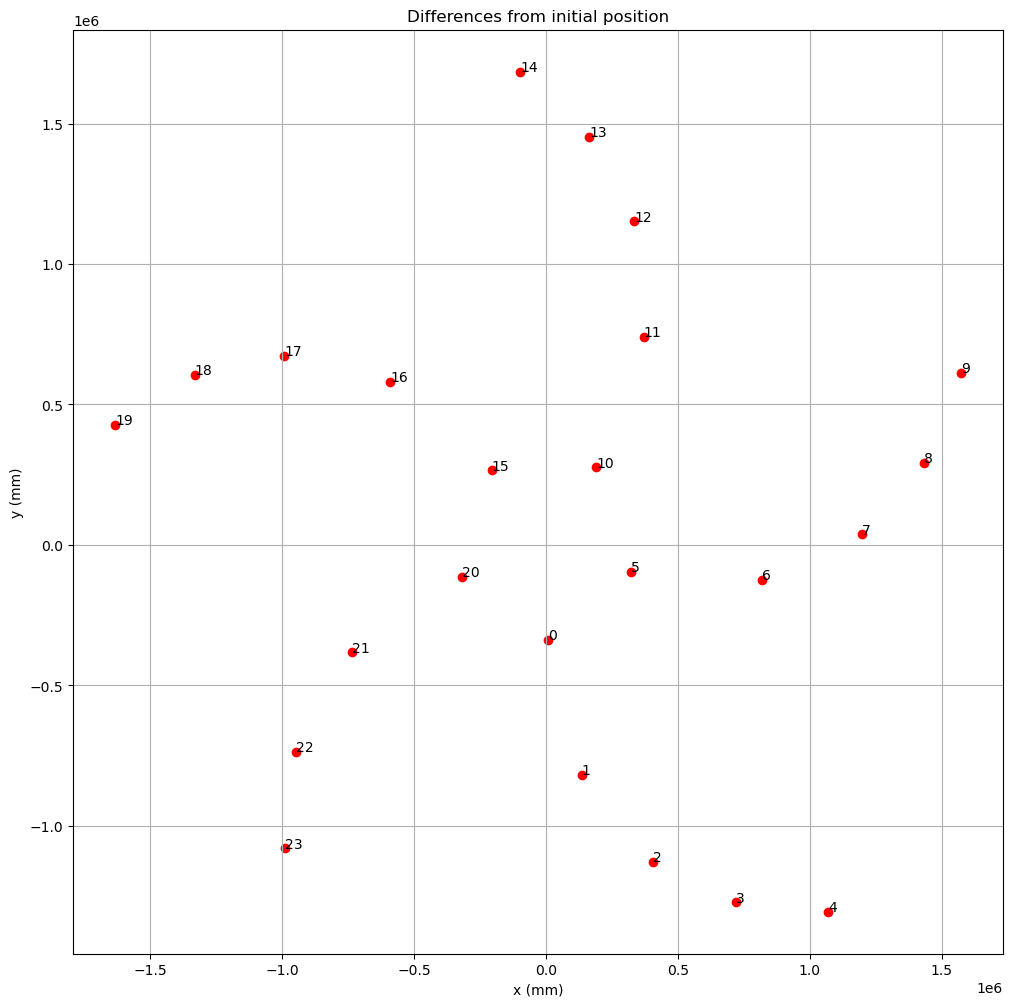

In [15]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [16]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0     1.323541
A 1     2.863477
A 2     1.584915
A 3    -0.455188
A 4     1.177016
A 5     2.899635
A 6     2.123720
A 7    -0.753617
A 8     0.948707
A 9    -0.114302
A 10    1.160438
A 11   -0.399055
A 12   -0.217227
A 13   -1.769724
A 14   -1.849491
A 15    2.659115
A 16   -0.909896
A 17    2.294236
A 18    8.473074
A 19   -1.538934
A 20    0.239465
A 21    0.606625
A 22   -1.709606
A 23   -5.333470
Name: 0, dtype: float64

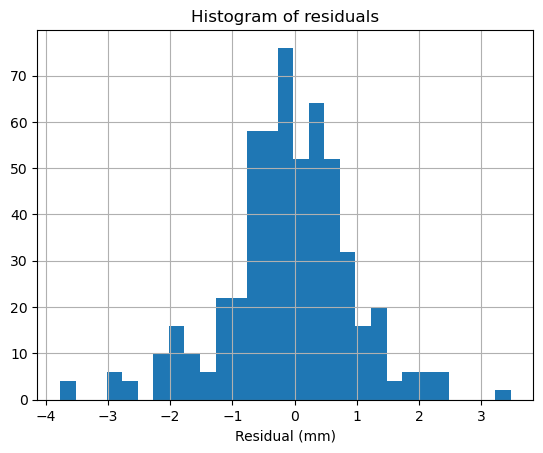

In [17]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [18]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 95)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95 and i > j:
        print(f" res[{i},{j}] = {r:3.1f}")
    ijres_matrix[i,j] = r
    


95th percentile of residuals is 2.19 mm
 res[13,11] = 2.4
 res[18,1] = -2.7
 res[18,2] = -3.0
 res[18,3] = -2.3
 res[18,4] = -2.9
 res[18,5] = -3.7
 res[18,6] = -3.8
 res[18,8] = -2.5
 res[18,10] = -2.3
 res[18,11] = -2.2
 res[20,18] = -2.9
 res[23,1] = 2.3
 res[23,13] = 3.5
 res[23,14] = 2.4


## Output best estimates

Write some json files...

In [19]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-0.278, -0.215,  0.   ],
       [-0.549, -0.735,  0.   ],
       [-0.429, -1.224,  0.   ],
       [-0.106, -1.541,  0.   ],
       [ 0.364, -1.733,  0.   ],
       [ 0.092, -0.261,  0.   ],
       [ 0.439, -0.707,  0.   ],
       [ 1.067, -0.783,  0.   ],
       [ 1.544, -0.482,  0.   ],
       [ 1.767, -0.182,  0.   ],
       [ 0.231,  0.   ,  0.   ],
       [ 0.861,  0.254,  0.   ],
       [ 1.056,  0.65 ,  0.   ],
       [ 1.007,  1.156,  0.   ],
       [ 0.676,  1.672,  0.   ],
       [ 0.101,  0.374,  0.   ],
       [-0.   ,  0.939,  0.   ],
       [-0.398,  1.235,  0.   ],
       [-0.853,  1.28 ,  0.   ],
       [-1.337,  1.182,  0.   ],
       [-0.305,  0.2  ,  0.   ],
       [-1.036,  0.226,  0.   ],
       [-1.427, -0.176,  0.   ],
       [-1.551, -0.863,  0.   ]])

In [20]:
json_result = {}
json_result["antenna_positions"] = result.tolist()

json_fname = f"{site_name}_processed_antenna_positions.json"
f = open(json_fname, "w")
f.write(json.dumps(json_result))
f.close()

pos_json = json.dumps(json_result, indent=4, separators=(',', ': '))
print(pos_json)

{
    "antenna_positions": [
        [
            -0.278,
            -0.215,
            0.0
        ],
        [
            -0.549,
            -0.735,
            0.0
        ],
        [
            -0.429,
            -1.224,
            0.0
        ],
        [
            -0.106,
            -1.541,
            0.0
        ],
        [
            0.364,
            -1.733,
            0.0
        ],
        [
            0.092,
            -0.261,
            0.0
        ],
        [
            0.439,
            -0.707,
            0.0
        ],
        [
            1.067,
            -0.783,
            0.0
        ],
        [
            1.544,
            -0.482,
            0.0
        ],
        [
            1.767,
            -0.182,
            0.0
        ],
        [
            0.231,
            0.0,
            0.0
        ],
        [
            0.861,
            0.254,
            0.0
        ],
        [
            1.056,
            0.65,
            

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


In [21]:
print(f"tart_upload_antenna_positions --api https://api.elec.ac.nz/tart/{site_name} --pw=xxxx --file {json_fname}")

tart_upload_antenna_positions --api https://api.elec.ac.nz/tart/za-hammanskraal --pw=xxxx --file za-hammanskraal_processed_antenna_positions.json
